In [603]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

SEED = 1234

In [604]:
df = pd.read_csv('../data/data_multidim/country_profile_variables.csv')

In [605]:
df.iloc[66,]

country                                                              Estonia
Region                                                        NorthernEurope
Surface area (km2)                                                     45227
Population in thousands (2017)                                          1310
Population density (per km2, 2017)                                      30.9
Sex ratio (m per 100 f, 2017)                                           88.2
GDP: Gross domestic product (million current US$)                      22460
GDP growth rate (annual %, const. 2005 prices)                           1.4
GDP per capita (current US$)                                         17112.0
Economy: Agriculture (% of GVA)                                          3.4
Economy: Industry (% of GVA)                                            27.4
Economy: Services and other activity (% of GVA)                         69.2
Employment: Agriculture (% of employed)                                  3.8

In [552]:
df.dtypes

country                                                        object
Region                                                         object
Surface area (km2)                                             object
Population in thousands (2017)                                  int64
Population density (per km2, 2017)                            float64
Sex ratio (m per 100 f, 2017)                                 float64
GDP: Gross domestic product (million current US$)               int64
GDP growth rate (annual %, const. 2005 prices)                 object
GDP per capita (current US$)                                  float64
Economy: Agriculture (% of GVA)                                object
Economy: Industry (% of GVA)                                  float64
Economy: Services and other activity (% of GVA)               float64
Employment: Agriculture (% of employed)                        object
Employment: Industry (% of employed)                           object
Employment: Services

In [553]:
df = df.applymap(lambda x: np.nan if x == -99 else x)

In [554]:
list_of_cols = ['Surface area (km2)', 'GDP growth rate (annual %, const. 2005 prices)', 'Economy: Agriculture (% of GVA)',
            'Employment: Agriculture (% of employed)', 'Employment: Industry (% of employed)', 'Employment: Services (% of employed)',
            'Unemployment (% of labour force)', 'International trade: Exports (million US$)', 'International trade: Imports (million US$)',
            'International trade: Balance (million US$)', 'Balance of payments, current account (million US$)',
            'Population growth rate (average annual %)', 'Urban population growth rate (average annual %)', 'Fertility rate, total (live births per woman)',
            'Refugees and others of concern to UNHCR (in thousands)', 'Infant mortality rate (per 1000 live births',
            'Health: Physicians (per 1000 pop.)', 'Education: Government expenditure (% of GDP)', 'Mobile-cellular subscriptions (per 100 inhabitants)',
            'Mobile-cellular subscriptions (per 100 inhabitants).1', 'Pop. using improved sanitation facilities (urban/rural, %)','Threatened species (number)']

In [555]:
def col_to_numeric(col):
    col = col.apply(lambda x: np.nan if x == '-99' else x)
    col = pd.to_numeric(col, errors='coerce')
    return col

In [556]:
df[list_of_cols] = df[list_of_cols].apply(col_to_numeric)

In [557]:
list_of_cols_paired = ['Labour force participation (female/male pop. %)', 'Life expectancy at birth (females/males, years)', 'Population age distribution (0-14 / 60+ years, %)',
                      'International migrant stock (000/% of total pop.)', 'Education: Primary gross enrol. ratio (f/m per 100 pop.)',
                      'Education: Secondary gross enrol. ratio (f/m per 100 pop.)', 'Education: Tertiary gross enrol. ratio (f/m per 100 pop.)',
                      'Forested area (% of land area)', 'Energy supply per capita (Gigajoules)', 'Pop. using improved drinking water (urban/rural, %)']

In [558]:
def seperate_paired_columns(col, df):
    col = col.apply(lambda x: np.nan if x == '-99' else x)
    tmp = col.str.split('/', 1, expand=True)
    tmp.columns = [col.name + "_option_A", col.name + "_option_B"]
    tmp = tmp.apply(pd.to_numeric, errors='coerce')
    df[tmp.columns.to_list()] = tmp

In [559]:
df[list_of_cols_paired] = df[list_of_cols_paired].apply(seperate_paired_columns, df=df)

In [560]:
df = df.drop(list_of_cols_paired, axis=1)

In [561]:
df1 = df[df.columns[df.isnull().sum()/len(df) <= 0.1]]
cor_matrix = df1.corr().abs()

In [562]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k =1 ).astype(np.bool))

In [563]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]

In [564]:
to_drop

['GDP: Gross domestic product (million current US$)',
 'Economy: Services and other activity (% of GVA)',
 'Food production index (2004-2006=100)',
 'International trade: Imports (million US$)',
 'Urban population growth rate (average annual %)',
 'Fertility rate, total (live births per woman)',
 'Mobile-cellular subscriptions (per 100 inhabitants).1',
 'CO2 emission estimates (million tons/tons per capita)',
 'Energy production, primary (Petajoules)',
 'Life expectancy at birth (females/males, years)_option_A',
 'Life expectancy at birth (females/males, years)_option_B',
 'Population age distribution (0-14 / 60+ years, %)_option_A',
 'Population age distribution (0-14 / 60+ years, %)_option_B',
 'International migrant stock (000/% of total pop.)_option_A',
 'International migrant stock (000/% of total pop.)_option_B',
 'Forested area (% of land area)_option_A',
 'Forested area (% of land area)_option_B']

In [565]:
df2 = df1.drop(to_drop, axis=1)

In [566]:
country = df2['country']
region = df2['Region']
df2 = df2.drop(['country', 'Region'], axis=1)

In [567]:
df2 = df2.fillna(df2.mean())

In [568]:
df2

,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)","GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Industry (% of GVA),Agricultural production index (2004-2006=100),International trade: Balance (million US$),Population growth rate (average annual %),Urban population (% of total population),Mobile-cellular subscriptions (per 100 inhabitants),Individuals using the Internet (per 100 inhabitants),Threatened species (number)
0,652864.0,35530,54.4,106.3,-2.400000,623.200000,23.300000,125.000000,-2110.000000,3.200000,26.7,61.600000,42.0,2.1
1,28748.0,2930,106.9,101.9,2.600000,3984.200000,26.000000,134.000000,-2707.000000,-0.100000,57.4,106.400000,130.0,28.2
2,2381741.0,41318,17.3,102.0,3.800000,4154.100000,37.300000,160.000000,-17099.000000,2.000000,70.7,113.000000,135.0,0.8
3,199.0,56,278.2,103.6,2.502899,15700.764423,27.565385,112.000000,-683.861905,1.348198,87.2,107.360287,92.0,87.9
4,468.0,77,163.8,102.3,0.800000,39896.400000,10.800000,116.184834,-1255.000000,-1.600000,85.1,88.100000,13.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,142.0,12,84.1,93.4,2.502899,15700.764423,27.565385,115.000000,-51.000000,-2.100000,0.0,107.360287,89.0,41.6
225,266000.0,553,2.1,110.1,2.502899,15700.764423,27.565385,100.000000,-683.861905,1.800000,80.9,107.360287,49.0,2.7
226,527968.0,28250,53.5,102.1,-28.100000,1106.400000,36.900000,136.000000,-6291.000000,2.600000,34.6,68.000000,298.0,1.0
227,752612.0,17094,23.0,98.5,2.900000,1311.100000,32.300000,179.000000,-937.000000,3.000000,40.9,74.500000,88.0,65.6


In [569]:
scaler = StandardScaler()
scaler.fit(df2)
X_transform = pd.DataFrame(scaler.transform(df2), columns=df2.columns)

In [570]:
%%time
tsne = TSNE(random_state=SEED, init='pca', n_jobs=-1)
X_tsne = tsne.fit_transform(X_transform)

CPU times: user 3.13 s, sys: 123 ms, total: 3.25 s
Wall time: 927 ms


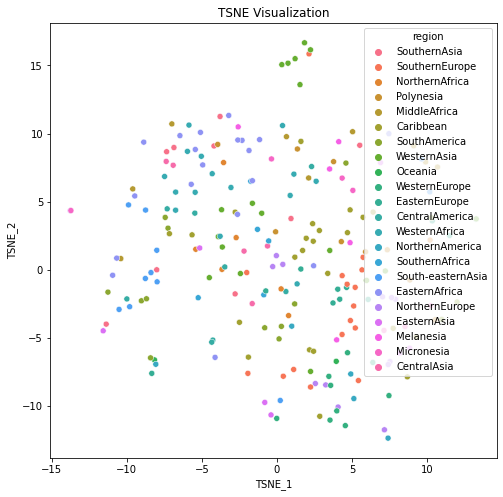

In [580]:
X_tsne = pd.DataFrame(X_tsne , columns=['TSNE_1', 'TSNE_2'])
X_tsne['region'] = region
plt.figure(figsize=(8, 8)) 
sns.scatterplot(data=X_tsne, x='TSNE_1', y='TSNE_2', hue='region', color='orange').set_title('TSNE Visualization');

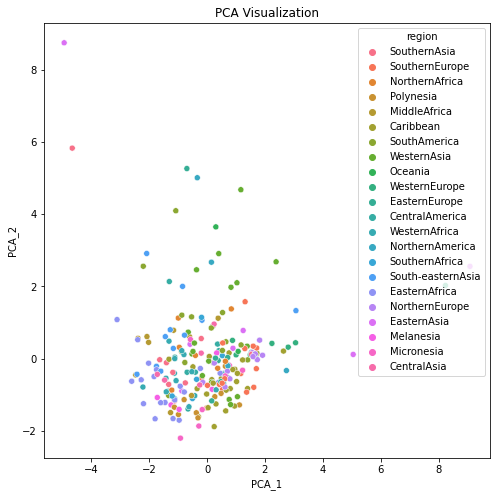

In [584]:
pca = PCA(n_components=2, random_state=SEED)
pca.fit(X_transform)
X_pca = pca.transform(X_transform)
X_pca = pd.DataFrame(X_pca, columns=['PCA_1', 'PCA_2'])
X_pca['region'] = region
plt.figure(figsize=(8, 8)) 
sns.scatterplot(data=X_pca, x='PCA_1', y='PCA_2', hue='region', color='blue').set_title('PCA Visualization');

In [588]:
pca = PCA()
X_pca = pca.fit_transform(X_transform)
exp_var_pca = pca.explained_variance_ratio_

In [589]:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

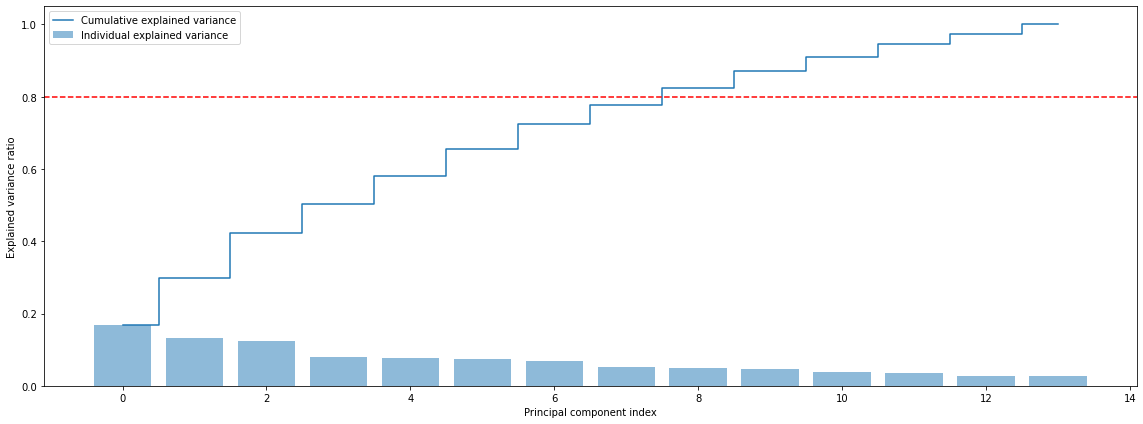

In [601]:
plt.figure(figsize=(16, 6)) 
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.axhline(y=0.8, color="red", linestyle='--')
plt.show()